In [3]:
#csvファイルを読み込む
import pandas as pd

# ファイルパス（適宜変更してください）
file_path = "sweden_energy_transition.csv"

# 読み込み
df = pd.read_csv(file_path)

# 先頭5行を確認
print(df.head())

# データの概要
print(df.info())



   year  draught \nanimal \nenergy  human \nenergy  humene \nfor \nwork  \
0  1800                       12.6            9.29                 1.56   
1  1801                       12.7            9.33                 1.57   
2  1802                       12.8            9.40                 1.59   
3  1803                       12.9            9.47                 1.60   
4  1804                       13.0            9.54                 1.62   

   humene \nfor \nfinal \nconsump \n-tion   total \nanimate \nenergy  \
0                                     7.73                     21.89   
1                                     7.75                     22.03   
2                                     7.81                     22.20   
3                                     7.87                     22.37   
4                                     7.92                     22.54   

   fire-\nwood \nhouse-\nholds  fire-\nwood \nindustry   \
0                        75.90                     7.62  

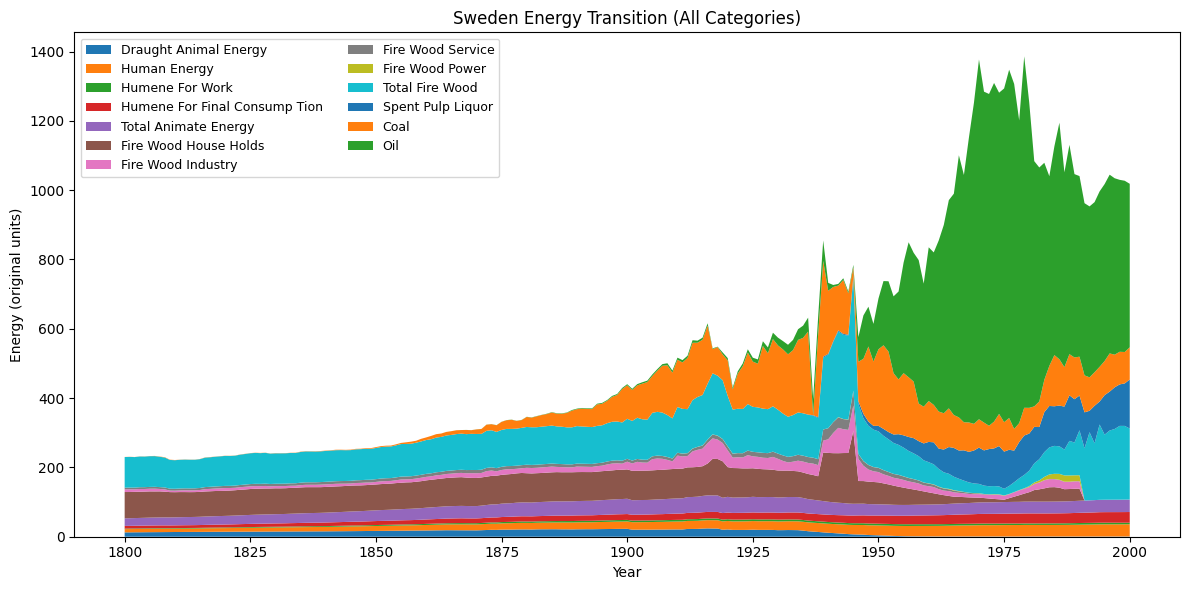

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# === 設定 ===
file_path = "sweden_energy_transition.csv"  # 実際のCSVファイル名に合わせる
USE_SHARES = False  # Trueにすると各年100%で割合の積み上げ

# === ヘルパー ===
def clean_col(s: str) -> str:
    s = re.sub(r"[\r\n]+", " ", str(s)).strip()
    s = re.sub(r"\s*-\s*", "_", s)
    s = re.sub(r"\s+", "_", s)
    return s.lower()

# === 読み込み ===
df_raw = pd.read_csv(file_path, header=None)
# 最初に4桁の年が出る行をデータ開始とみなす
year_row_idx = df_raw.apply(lambda r: bool(re.match(r"^\s*\d{4}\s*$", str(r.iloc[0]))), axis=1).idxmax()
header_idx = max(0, year_row_idx - 1)
cols = df_raw.iloc[header_idx].map(clean_col).tolist()
df = df_raw.iloc[year_row_idx:].copy()
df.columns = cols[: len(df.columns)]

# 年列を特定
year_col = None
for c in df.columns:
    if "year" in c:
        year_col = c
        break
if year_col is None:
    year_col = df.columns[0]

# 数値化
df[year_col] = pd.to_numeric(df[year_col], errors="coerce")
for c in df.columns:
    if c != year_col:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=[year_col]).sort_values(year_col).reset_index(drop=True)

# === 全列使用 ===
energy_cols = [c for c in df.columns if c != year_col]
Y = df[energy_cols].fillna(0).copy()

# 割合にしたい場合
if USE_SHARES:
    row_sum = Y.sum(axis=1).replace(0, np.nan)
    Y = Y.div(row_sum, axis=0) * 100.0
    y_label = "Share (%)"
else:
    y_label = "Energy (original units)"

labels = [re.sub(r"_", " ", c).title() for c in energy_cols]

# === 積み上げグラフ ===
plt.figure(figsize=(12, 6))
plt.stackplot(df[year_col], *[Y[c] for c in energy_cols], labels=labels)
plt.legend(loc="upper left", ncol=2, fontsize=9)
plt.xlabel("Year")
plt.ylabel(y_label)
plt.title("Sweden Energy Transition (All Categories)")
plt.tight_layout()
plt.show()
